# Защита персональных данных клиентов

Была разработана модель анонимизации клиентов. 

Используя признаки линейной алгебры я добился анонимизации личной информации клиентов с возможностью анализа этих данных

## Загрузка данных

In [1]:
from io import BytesIO
import requests

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
RANDOM_STATE = 11111

In [3]:
def get_data_csv(sheet_id:str) -> pd.DataFrame:
    url = f"https://docs.google.com/spreadsheets/d/{sheet_id}" \
          f"/export?format=csv"
    
    r = requests.get(url)
    data = pd.read_csv(BytesIO(r.content))
    return data

In [4]:
try:
    data = pd.read_csv('../datasets/insurance.csv')
except:
    pass

## EDA

In [5]:
display(data.info())
print('-'*80)
display(data.head())
print('-'*80)
display(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


None

--------------------------------------------------------------------------------


,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


--------------------------------------------------------------------------------


,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


In [6]:
print(sum(data['Возраст'] % 1))
print(sum(round(data['Зарплата'],2) % 1))

0.0
0.0


In [7]:
data = data.astype({
    'Возраст':'int',
    'Зарплата' : 'int'
})

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Пол                5000 non-null   int64
 1   Возраст            5000 non-null   int32
 2   Зарплата           5000 non-null   int32
 3   Члены семьи        5000 non-null   int64
 4   Страховые выплаты  5000 non-null   int64
dtypes: int32(2), int64(3)
memory usage: 156.4 KB


Ничего необычного в данных нет. Видно, что представлено 5 переменных. Выбросов и отклонений нет. Для удобства переименуем колонки

In [9]:
data = data.rename(columns = {
    'Пол' : 'sex',
    'Возраст' : 'age',
    'Зарплата' : 'salary',
    'Члены семьи' : 'family_members',
    'Страховые выплаты' : 'insurance_payments',  
})

Построим pairplot

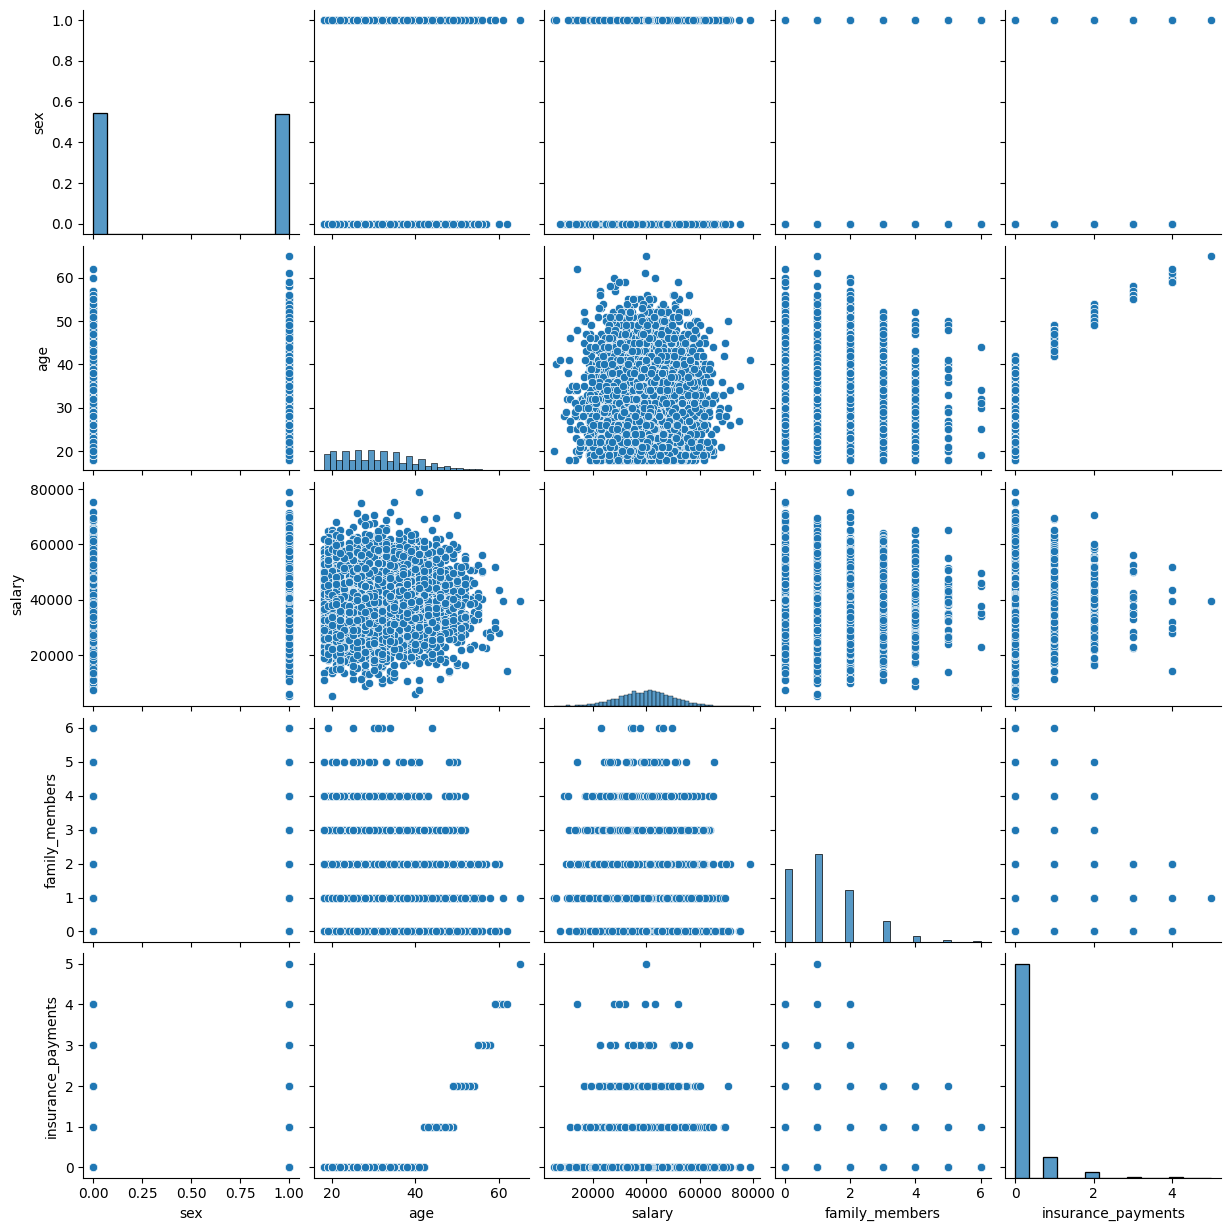

In [10]:
sns.pairplot(data)
plt.show()

Выводы:
- Мужчин и женщин представлено поровну
- Страховые выплаты начинаются с 40 лет
- В данных отклонений не наблюдается

**Проверка на дубликаты**

In [11]:
data.duplicated().sum()

153

In [12]:
data = data.drop_duplicates(ignore_index = True)

Дубликаты удалены

**Матрица корреляций**

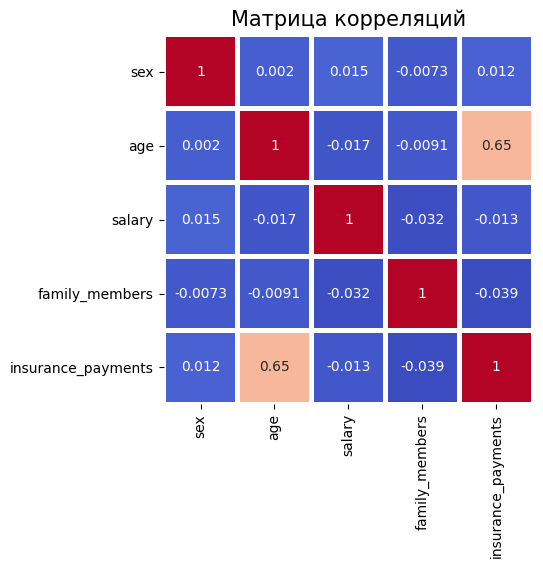

In [13]:
plt.title("Матрица корреляций", fontsize =15)
sns.heatmap(data.corr(),annot = True, cmap= 'coolwarm',
            linewidths = 3, cbar= False, square=True)

plt.show()

Мы видим среднюю корреляцию между возрастом и страховыми выплатами. Но ранее по paitplot мы видели, что там зависимость не линейная

**эксперимент со страховыми выплатами**

В качестве эксперимента попробуем предсказать количество страховых признаков от возраста

- Судя по графику до 40 лет клиент не получает страховые выплаты. Поэтому не будет их учитывать результат, с высокой долей вероятности до 40 лет клиент страховых выплат не получит

In [14]:
data_temp = data.copy()
data_temp = data_temp[data_temp['age'] > 40]

In [15]:
np.corrcoef(data_temp.age,data_temp['insurance_payments'])

array([[1.        , 0.90759479],
       [0.90759479, 1.        ]])

То есть мы имеем сильную корреляцию между признаками и можем добиться высокой точности разделив датасеты. Тем не менее будем придерживаться условия задачи

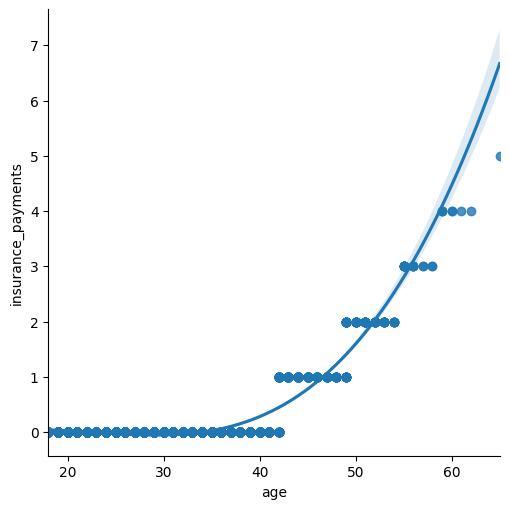

In [16]:
sns.lmplot(data = data, x = 'age', y = 'insurance_payments',order = 3)

## Разделение данных

In [17]:
features = data.drop(columns = 'insurance_payments')
target = data['insurance_payments']

In [18]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size = .25, random_state=RANDOM_STATE
)

## Умножение матриц

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

In [19]:
class LinearRegression:
    def fit(self, train_features, train_target):
        # добавляем нулевой столбец, который состоит из единиц
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)
        y = train_target
        # вычисляем вектор весов по формуле обучения
        w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        self.w = w[1:]
        self.w0 = w[0]

    def predict(self, test_features):
        return round(test_features.dot(self.w) + self.w0)

In [20]:
model = LinearRegression()
model.fit(features_train, target_train)
predictions = model.predict(features_test)

In [21]:
print(f'r2_score модели {r2_score(target_test, predictions):.4f}')

r2_score модели 0.6070


## Доказательство

Предсказания:

$
a = Xw
$

$
w = (X^T X)^{-1} X^T y
$

Обратимую матрицу представим большой А

$
A
$

Далее мы преобразуем формулу обучения.
Посдставляем значения и по свойствам матриц выносим A за пределы основной формулы


$
w1 = ((XA)^T XA)^{-1} (XA)^T = (A^T X^T X A)^{-1} A^T X ^T = A^{-1} (X^T X)^{-1}  (A^T)^{-1}A^T X ^T
$


$
(A^T)^{-1}A^T = E
$

$
w1 =  A^{-1} (X^T X)^{-1}  X ^T = A^{-1} (X^T X)^{-1} X^T y = A^{-1} w 
$

Подставляем полученную формулу в формулу предсказания, E сокращаем, так как при умножении на единичную матрицу матрица не меняется

$
a = X  A A^{-1} w  = xw
$

Итого значение не поменялось

Декодирование. Для декодирования надо умножить x на обратную матрицу

## Алгоритм преобразования

 Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии?

In [22]:
r = np.random.RandomState(RANDOM_STATE)

class ConvertData:

    def __init__(self, size):
        self.size = size
        self.martix = self.get_invertible_matrix()
    
    def get_invertible_matrix(self):
        while(True):
            matrix = r.normal(size = (self.size, self.size))
            if self._check_invertible_matrix(matrix) == True:
                return matrix
    
    def _check_invertible_matrix(self, matrix):
        try:
            np.linalg.inv(matrix)
            return True
        except:
            return False
        
    def get_modern_data(self, features_train):
        return features_train.dot(self.martix)
    
    def decode_data(self, features_train_M):
        return round(features_train_M.dot(np.linalg.inv(self.martix)),2)


In [23]:
model = LinearRegression()
model.fit(features_train, target_train)
predictions = model.predict(features_test)
print(f'r2_score модели {r2_score(target_test, predictions):.4f}')

r2_score модели 0.6070


In [24]:
convert = ConvertData(features_train.shape[1])
features_train_m = convert.get_modern_data(features_train)
features_test_m= convert.get_modern_data(features_test)

In [25]:
model = LinearRegression()
model.fit(features_train_m, target_train)
predictions = model.predict(features_test_m)
print(f'r2_score модели {r2_score(target_test, predictions):.4f}')

r2_score модели 0.6070


**Ответ**: умножение признаков не обратимую матрицу не влияет на качество модели

Также в данном блоке есть класс ConvertData, который умножает нужную матрицу на обратимую матрицу

## Выводы

- Если умножать признаки на обратимую матрицу, то качество регрессионной модели не меняется
- В проекте не использовались сторонние библиотеки и алгоритм линейной регрессии был реализован при помощи формул
- Для того, чтобы скрыть данные, достаточно умножить train и predict на обратимую матрицу. Матрица должна быть одна и та же
- Был реализован класс, который создавал матрицу размером 4 на 4, проверял, является ли она обратимой и умножал на неё признаки